In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs


In [2]:
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42
X,y=make_blobs(n_samples=2000,
               n_features=NUM_FEATURES,
               centers=NUM_CLASSES,
               cluster_std=1.5,
               random_state=RANDOM_SEED
               )
X.shape,y.shape

((2000, 2), (2000,))

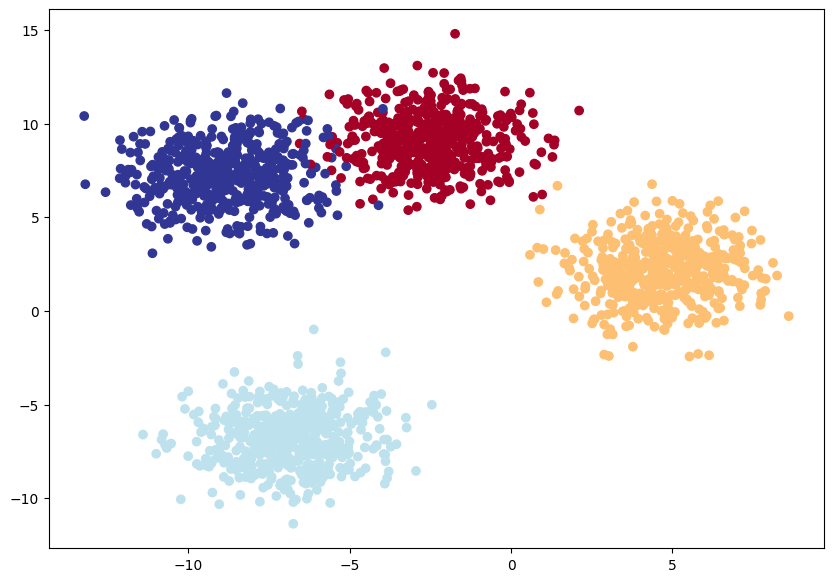

In [3]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],c=y,cmap='RdYlBu')

In [4]:
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

In [5]:
class MultiClassClassifier(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=10):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)

In [6]:
if torch.cuda.is_available():
    device='cuda'
elif torch.backends.mps.is_available():
    device=torch.device("mps")
else:
    device='cpu'
print(f"Using device = {device}")

Using device = mps


In [7]:
model_1=MultiClassClassifier(input_features=2,output_features=4)
model_1.to(device)

MultiClassClassifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [8]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [9]:
model_1.eval()
with torch.inference_mode():
    y_logits=model_1(X_test.to(device))
y_logits[:10]

tensor([[-0.9885, -0.2145,  0.2437, -1.3040],
        [-0.9375,  0.2586,  0.5983,  0.0258],
        [-1.5285,  0.4320,  0.8371, -0.5576],
        [-1.1413,  0.2797,  0.4716, -0.1367],
        [-1.3832,  0.3912,  0.6954, -0.5109],
        [-1.3927,  0.4017,  0.7657, -0.5329],
        [-0.4137,  0.0770, -0.0425, -0.2332],
        [-0.3958,  0.1486, -0.1680, -0.3611],
        [-1.4630,  0.4169,  0.7991, -0.5446],
        [-0.9334, -0.0079,  0.3665, -0.8858]], device='mps:0')

In [10]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[0.1365, 0.2960, 0.4680, 0.0996],
        [0.0864, 0.2858, 0.4014, 0.2264],
        [0.0467, 0.3320, 0.4978, 0.1234],
        [0.0776, 0.3213, 0.3893, 0.2119],
        [0.0579, 0.3412, 0.4625, 0.1384],
        [0.0554, 0.3336, 0.4800, 0.1310],
        [0.1894, 0.3093, 0.2745, 0.2268],
        [0.1994, 0.3437, 0.2504, 0.2065],
        [0.0509, 0.3333, 0.4884, 0.1274],
        [0.1213, 0.3062, 0.4452, 0.1273]], device='mps:0')

In [11]:
y_pred=torch.argmax(y_pred_probs,dim=1)
y_pred[:10]

tensor([2, 2, 2, 2, 2, 2, 1, 1, 2, 2], device='mps:0')

In [14]:

epochs = 3000
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    ###Trading
    model_1.train()
    #1. Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

    #2. Compute Loss
    loss = loss_fn(y_logits, y_train)

    #3. Zero grad optimizer resets all gradient befroe calculating new gradient
    optimizer.zero_grad()

    #4. Backpropagate
    loss.backward()

    #5. Step the optimer
    optimizer.step()
    acc=accuracy_score(y_true=y_train.cpu().detach().numpy(),y_pred=y_preds.cpu().detach().numpy())
    # testing
    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_loss=loss_fn(test_logits,y_test)
        acc=accuracy_score(y_true=y_train.cpu().detach().numpy(),y_pred=y_preds.cpu().detach().numpy())
    if (epoch%200==0):
        print(f"Epochs:{ epoch} Trains_loss { loss:.5f} test_loss {test_loss:.5f} test_accuracy{acc*100}")
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epochs:0 Trains_loss 0.02992 test_loss 0.02191 test_accuracy99.0
Epochs:200 Trains_loss 0.02985 test_loss 0.02183 test_accuracy98.9375
Epochs:400 Trains_loss 0.02979 test_loss 0.02175 test_accuracy98.9375
Epochs:600 Trains_loss 0.02973 test_loss 0.02168 test_accuracy98.9375
Epochs:800 Trains_loss 0.02967 test_loss 0.02161 test_accuracy98.9375
Epochs:1000 Trains_loss 0.02961 test_loss 0.02154 test_accuracy98.9375
Epochs:1200 Trains_loss 0.02956 test_loss 0.02147 test_accuracy98.9375
Epochs:1400 Trains_loss 0.02951 test_loss 0.02141 test_accuracy98.9375
Epochs:1600 Trains_loss 0.02945 test_loss 0.02134 test_accuracy98.9375
Epochs:1800 Trains_loss 0.02940 test_loss 0.02128 test_accuracy98.9375
Epochs:2000 Trains_loss 0.02935 test_loss 0.02122 test_accuracy98.9375
Epochs:2200 Trains_loss 0.02931 test_loss 0.02116 test_accuracy98.9375
Epochs:2400 Trains_loss 0.02926 test_loss 0.02110 test_accuracy98.9375
Epochs:2600 Trains_loss 0.02921 test_loss 0.02105 test_accuracy98.9375
Epochs:2800 Trai

In [15]:
from helper import plot_decision_boundary(train_data, train_labels, test_data, test_labels, predictions=None)

SyntaxError: invalid syntax (446191462.py, line 1)